### Cartpole

In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
class PolicyNetwork():
    def __init__(self, name, learning_rate=0.01, state_size=4, action_size=2):
        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs_ = tf.placeholder(tf.float32, [None, state_size])
                self.actions_ = tf.placeholder(tf.int32, [None, action_size])
                self.discounted_episodes_rewards_ = tf.placeholder(tf.float32, [None,])

            with tf.name_scope("layers"):
                self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, 32, weights_initializer=tf.contrib.layers.xavier_initializer())
                self.fc2 = tf.contrib.layers.fully_connected(self.fc1, 64, weights_initializer=tf.contrib.layers.xavier_initializer())
                self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 32, activation_fn=None, weights_initializer=tf.contrib.layers.xavier_initializer())
            
            with tf.name_scope("flatten"):
                self.flatten = tf.contrib.layers.flatten(self.fc3)
                self.logits = tf.layers.dense(inputs = self.flatten, units = 2, activation = tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
            
            with tf.name_scope("softmax"):
                self.action_distribution = tf.nn.softmax(self.logits)
            
            with tf.name_scope("loss"):
                self.log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logits, labels = self.actions_)
                self.loss = tf.reduce_mean(self.log_prob * self.discounted_episodes_rewards_)
                self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

class Baseline():
    def __init__(self, name, learning_rate=0.01, state_size=4):
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size])
            self.discounted_episodes_rewards_ = tf.placeholder(tf.float32, [None,])
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, 10,weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, 8, weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 1, activation_fn=None, weights_initializer=tf.contrib.layers.xavier_initializer())
            self.loss = tf.reduce_mean(tf.square(self.fc3 - self.discounted_episodes_rewards_))
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [3]:
def discount_rewards(r, gamma = 0.95):
    discount_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(r))):
        running_add = running_add * gamma + r[t]
        discount_r[t] = running_add      
    return list(discount_r)

In [4]:
env = gym.make('CartPole-v0')
n_actions = env.action_space.n 

In [5]:
gamma = 0.95 # discount rate
learning_rate = 0.01
state_size = 4
episodes = 100
epochs = 100
tf.reset_default_graph()
cartpole = PolicyNetwork(name = 'trial', learning_rate=learning_rate, state_size=state_size, action_size=n_actions)
baseline = Baseline(name = 'baseline', learning_rate=learning_rate, state_size=state_size)

env.reset()
all_rewards = []
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        all_states, all_actions, all_discount_rewards = [], [], []
        running_rewards = []
        for episode in range(episodes):
            state = env.reset()
            episode_rewards = []
            while True:            
                action_dist = sess.run(cartpole.action_distribution, feed_dict={cartpole.inputs_: state.reshape((1,*state.shape))})
                action = np.random.choice(range(action_dist.shape[1]), p=action_dist.ravel())
                new_state, reward, done, _ = env.step(action)
                all_states.append(state)
                episode_rewards.append(reward)
                which_action = np.zeros(action_dist.shape[1])
                which_action[action] = 1
                all_actions.append(which_action)
                state = new_state
                if done:
                    dis_rewards = discount_rewards(episode_rewards)
                    all_discount_rewards += dis_rewards
                    running_rewards.append(sum(episode_rewards))
                    break
        
        original_r = all_discount_rewards.copy()
        baseline_r = sess.run(baseline.fc3, feed_dict={baseline.inputs_ : np.vstack(all_states)})
        all_discount_rewards -= np.hstack(baseline_r)
        _, _= sess.run([baseline.loss, baseline.learn],feed_dict={baseline.inputs_: np.vstack(all_states),baseline.discounted_episodes_rewards_: original_r })
        _, _= sess.run([cartpole.loss, cartpole.learn], feed_dict={cartpole.inputs_: np.vstack(all_states),cartpole.actions_: np.vstack(all_actions), cartpole.discounted_episodes_rewards_: all_discount_rewards })      
        all_rewards.append(np.mean(running_rewards))



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


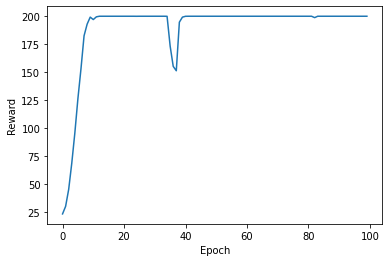

In [6]:
plt.plot(all_rewards)
plt.ylabel('Reward')
plt.xlabel('Epoch')
plt.savefig('Cartpole.png',bbox_inches='tight',facecolor="#FFFFFF")
plt.show()  